In [1]:
import pair
from pair import Pair
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from keras.models import Sequential, load_model
from keras import layers
from keras.callbacks import EarlyStopping
from keras import optimizer_v2 as opt
import os

In [2]:
#import data
eur = Pair('EURUSD', key='removed for my own safety', mode='hourly')
eur.ts = pd.DataFrame(eur.ts)

In [3]:
#adding 2 SMAs and 2 sigmas
shorter = 5
longer = 15

sma_long = [None] * 15
sma_short = [None] * 5
std_long = [None] * 15
std_short = [None] * 5

for i in range(len(eur.ts) - 5):
    sma_short.append(np.mean(eur.ts.close[i:i+5]))
    std_short.append(np.std(eur.ts.close[i:i+5]))

    if not i >= len(eur.ts) - 15:
        sma_long.append(np.mean(eur.ts.close[i:i+15]))
        std_long.append(np.std(eur.ts.close[i:i+15]))

eur.ts['SMA_short'] = sma_short
eur.ts['STD_short'] = std_short
eur.ts['SMA_long'] = sma_long
eur.ts['STD_long'] = std_long

df = eur.ts[['open', 'high', 'low', 'close', 'SMA_short', 'STD_short', 'SMA_long', 'STD_long']].iloc[15:,:].reset_index(drop=True)
labels = df.close[1:].reset_index(drop=True)
features = df.iloc[:-1,:]

In [4]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=.15)
ct = ColumnTransformer([('only numeric', StandardScaler(), features.columns)], remainder='passthrough')
train_features = ct.fit_transform(train_features)
test_features = ct.fit_transform(test_features)
all_features = ct.fit_transform(df)

In [5]:
model: Sequential
loss = 'mse'
metrics = ['mape','mae']
build = 0

def build_model(name: str = 'FXr', metrics = metrics, loss = loss):
    model = Sequential(name = name)
    model.add(layers.InputLayer((features.shape[1],1)))
    model.add(layers.Dense(512, activation='relu'))
    # model.add(layers.Dropout(.1))
    model.add(layers.Dense(256, activation='relu'))
    # model.add(layers.Dropout(.1))
    model.add(layers.Dense(128, activation='relu'))
    # model.add(layers.Dropout(.1))
    model.add(layers.Dense(128, activation='relu'))
    # model.add(layers.Dropout(.1))
    model.add(layers.Dense(32, activation='relu'))
    # model.add(layers.Dropout(.1))
    model.add(layers.Dense(8, activation='relu'))
    # model.add(layers.Dropout(.1))
    model.add(layers.Dense(1, name='Output'))
    model.compile(loss=loss, optimizer=opt.adam.Adam(learning_rate=0.00002), metrics=metrics)
    print(f'Generating new model {model.name}')
    model.summary()
    return model

if 'model' not in dir() or build: model = build_model()
else: print('Loaded previous model:'); model.summary()

2023-05-25 21:25:57.988180: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Generating new model FXr
Model: "FXr"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8, 512)            1024      
                                                                 
 dense_1 (Dense)             (None, 8, 256)            131328    
                                                                 
 dense_2 (Dense)             (None, 8, 128)            32896     
                                                                 
 dense_3 (Dense)             (None, 8, 128)            16512     
                                                                 
 dense_4 (Dense)             (None, 8, 32)             4128      
                                                                 
 dense_5 (Dense)             (None, 8, 8)              264       
                                                                 
 Output (Dense)              (None, 8,

In [6]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=150, restore_best_weights=True)
history = model.fit(train_features, train_labels, epochs=5000, batch_size=3, validation_split=.175, verbose=2, callbacks=[es])

Epoch 1/5000
114/114 - 2s - loss: 1.1465 - mape: 98.0799 - mae: 1.0704 - val_loss: 1.0717 - val_mape: 94.8295 - val_mae: 1.0348 - 2s/epoch - 19ms/step
Epoch 2/5000
114/114 - 1s - loss: 0.9447 - mape: 88.8052 - mae: 0.9691 - val_loss: 0.7888 - val_mape: 80.9450 - val_mae: 0.8833 - 504ms/epoch - 4ms/step
Epoch 3/5000
114/114 - 0s - loss: 0.5330 - mape: 64.3970 - mae: 0.7027 - val_loss: 0.3044 - val_mape: 46.1207 - val_mae: 0.5035 - 481ms/epoch - 4ms/step
Epoch 4/5000
114/114 - 1s - loss: 0.2035 - mape: 34.1739 - mae: 0.3729 - val_loss: 0.1718 - val_mape: 30.9051 - val_mae: 0.3370 - 501ms/epoch - 4ms/step
Epoch 5/5000
114/114 - 0s - loss: 0.1574 - mape: 28.8646 - mae: 0.3148 - val_loss: 0.1473 - val_mape: 28.4529 - val_mae: 0.3102 - 489ms/epoch - 4ms/step
Epoch 6/5000
114/114 - 0s - loss: 0.1334 - mape: 26.5897 - mae: 0.2900 - val_loss: 0.1228 - val_mape: 25.8033 - val_mae: 0.2813 - 479ms/epoch - 4ms/step
Epoch 7/5000
114/114 - 0s - loss: 0.1094 - mape: 23.9586 - mae: 0.2613 - val_loss: 0

In [7]:
#metrics of fit
test_predictions = [float(p[0]) for p in model.predict(test_features)]
predictions = [float(p[0]) for p in model.predict(all_features)]
residuals = [prediction - actual for prediction, actual in zip(predictions[:-1], labels)]
absolute_residuals = [abs(r) for r in residuals]
test_r2 = r2_score(test_labels, test_predictions)

print(f'-*- Metrics for {model.name} -*-\nResiduals:\n\t|Max|: ${max(absolute_residuals):4f}\n\t|Min|: ${min(absolute_residuals):.4f}\n\tAverage: ${np.mean(residuals):.4f}\nTest R-squared: {test_r2}')

-*- Metrics for FXr -*-
Residuals:
	|Max|: $0.006124
	|Min|: $0.0000
	Average: $0.0005
Test R-squared: 0.960352584834825


Text(0, 0.5, 'Frequency')

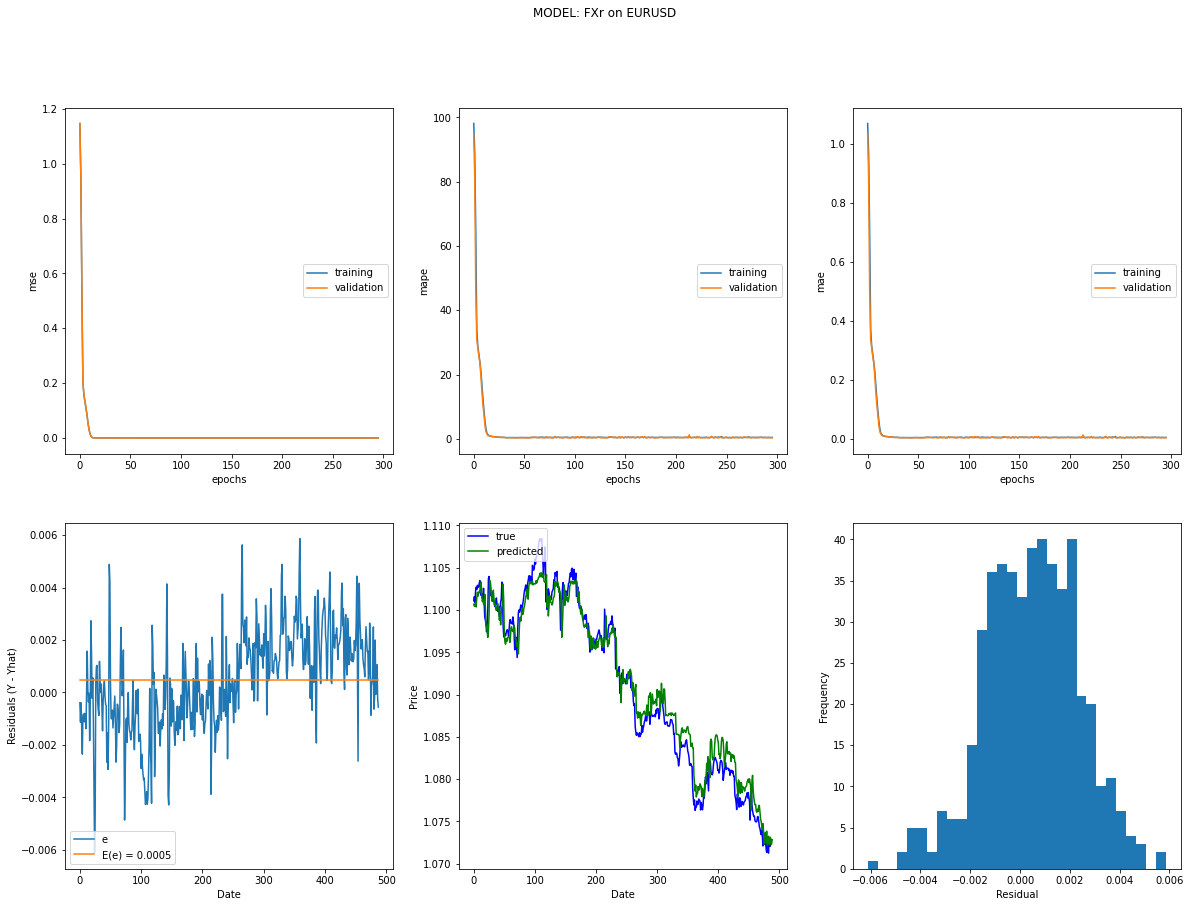

In [8]:
#graphs
fig = plt.figure('Evaluation', figsize=(20,14))
fig.suptitle(f'MODEL: {model.name} on {eur.pair}')

ax1 = fig.add_subplot(2,3,1)
ax1.plot(history.history['loss'], label='training')
ax1.plot(history.history['loss'], label='validation')
ax1.set_xlabel('epochs')
ax1.set_ylabel(loss)
ax1.legend(loc='center right')

ax2 = fig.add_subplot(2,3,2)
ax2.plot(history.history[f'{metrics[0]}'], label='training')
ax2.plot(history.history[f'val_{metrics[0]}'], label='validation')
ax2.set_xlabel('epochs')
ax2.set_ylabel(metrics[0])
ax2.legend(loc='center right')

ax3 = fig.add_subplot(2,3,3)
ax3.plot(history.history[f'{metrics[1]}'], label='training')
ax3.plot(history.history[f'val_{metrics[1]}'], label='validation')
ax3.set_xlabel('epochs')
ax3.set_ylabel(metrics[1])
ax3.legend(loc='center right')

ax4 = fig.add_subplot(2,3,4)
ax4.plot(range(len(residuals)), residuals, label='e')
ax4.plot([np.mean(residuals) for _ in range(len(residuals))], label=f'E(e) = {np.mean(residuals):.4f}')
ax4.set_xlabel('Date')
ax4.set_ylabel('Residuals (Y - Yhat)')
ax4.legend(loc='lower left')

ax5 = fig.add_subplot(2,3,5)
ax5.plot(range(len(labels)), labels, label='true', color='blue')
ax5.plot(predictions, label='predicted', color='green')
ax5.set_xlabel('Date')
ax5.set_ylabel('Price')
ax5.legend(loc='upper left')

ax6 = fig.add_subplot(2,3,6)
ax6.hist(residuals, 30)
ax6.set_xlabel('Residual')
ax6.set_ylabel('Frequency')

In [9]:
print(f'Prediction for t+1: ${predictions[-1]:.4f}')

Prediction for t+1: $1.0728


In [10]:
#save model
model.save(f'h5s/{model.name}{eur.mode[0]}{int(test_r2*100)}')

2023-05-25 21:28:26.711140: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: h5s/FXrh96/assets
